In [9]:
# Keras Geant3 Events to True table convolutional autoencoder
import sys, os
print(os.path.dirname(sys.executable))

import pickle
import time
import os
from sys import platform

import numpy as np
import matplotlib.pyplot as plt

from event_display import print_tabled_event

from keras.models import Sequential
from keras.layers import Dense, MaxPooling2D, Conv2D, Flatten, UpSampling2D, Cropping2D, Input, Conv2DTranspose, Dropout
from keras.utils import plot_model
#import tensorflow as tf
#import keras
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
#print(tf.version)
#keras.backend.tensorflow_backend.set_session(tf.Session(config=config))


/home/romanov/anaconda3/envs/ai/bin


In [10]:
import pandas as pd

all_vals_df = pd.read_feather("/mnt/work/data/epi/2022-11-29_cherepaha_SciGlass-4-1-L_13x13_20x20x200mm_1-10GeV_e-pi-_10kev-each.feather")
all_vals_df["e_div_p"] = all_vals_df.de_sum/(all_vals_df.p*1000)
all_vals_df.head()

,p,prt_name,de_sum,towers,e_div_p
0,1.0,e-,745.830705,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.745831
1,1.0,e-,723.557254,"[0.0, 0.0, 0.33505856326162586, 0.0, 0.0, 0.0,...",0.723557
2,1.0,e-,810.117192,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.810117
3,1.0,e-,853.066921,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.853067
4,1.0,e-,879.492094,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.879492


In [11]:
towers = np.stack(all_vals_df.towers.to_numpy())
np.shape(towers)
e_answers = np.where(all_vals_df.prt_name == "e-", 1, 0)
pi_answers = np.where(all_vals_df.prt_name == "pi-", 1, 0)
answers = np.column_stack((e_answers, pi_answers))

In [12]:
inputs = towers

print(f"Inputs shape original = {np.shape(inputs)}")
print(f"answers shape original = {np.shape(answers)}")
print(f"max hit value = {np.max(inputs)}")
# print(f"max e = {np.max(true_e)}")


inputs = np.reshape(inputs, (len(inputs), 13, 13, 1))  # -1 => autodetermine
#answers = np.reshape(answers, (len(answers), 1))  # -1 => autodetermine
# # Pad with 1 row and column of zeroes, so it divides by 2
#inputs = np.pad(inputs, ((0,0), (0,1), (0,1), (0,0)), mode='constant', constant_values=0)
#answers = np.pad(answers, ((0,0), (0,1), (0,1), (0,0)), mode='constant', constant_values=0)
print(f"Inputs shape new = {np.shape(inputs)}")
print(f"Answers shape new = {np.shape(answers)}")


Inputs shape original = (200000, 169)
answers shape original = (200000, 2)
max hit value = 5814.889844006649
Inputs shape new = (200000, 13, 13, 1)
Answers shape new = (200000, 2)


In [13]:

# print_tabled_event(inputs[0])
# print(answers[0])
# #print_tabled_event(answers[0]*11)
# #print("-----------------------------------")
# #print_tabled_event(inputs[1]*11)
# #print_tabled_event(answers[1]*11)



In [14]:
model = Sequential()
model.add(Input(shape=(13, 13, 1)))
model.add(Conv2D(64, kernel_size=(2, 2), activation='relu', kernel_initializer='he_normal'))
model.add(Conv2D(32, kernel_size=(2, 2), activation='relu', kernel_initializer='he_normal'))
model.add(Conv2D(16, kernel_size=(2, 2), activation='relu', kernel_initializer='he_normal'))
model.add(Conv2D(6, kernel_size=(2, 2), activation='relu', kernel_initializer='he_normal'))
#model.add(Dropout(0.1))
#model.add(MaxPooling2D(pool_size=(1,1)))
model.add(Flatten())
## 128 -> 216
## 64  -> 294
model.add(Dense(294, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(2, activation='softmax'))
# model.add(Dense(20, activation='relu'))
# model.add(Dense(274, activation='relu'))
# model.add(Dense(264, activation='relu'))
# model.add(Dense(254, activation='relu'))
# model.add(Dense(242, activation='relu'))
# model.add(Dense(222, activation='relu'))
# model.add(Dense(202, activation='relu'))
# model.add(Dense(182, activation='relu'))
# model.add(Dense(162, activation='relu'))
# model.add(Dense(142, activation='relu'))
# model.add(Dense(121, activation='relu'))
#model.add(Conv2D(1, kernel_size=(2, 2), activation='sigmoid', padding='same'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 12, 12, 64)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 32)        8224      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 10, 10, 16)        2064      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 9, 9, 6)           390       
_________________________________________________________________
flatten_1 (Flatten)          (None, 486)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 294)               143178    
_________________________________________________________________
dense_4 (Dense)              (None, 100)              

In [15]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc', 'mse', 'mae'])
# output layer
#model.compile(optimizer='adam', loss='mean_squared_error', metrics=['acc', 'mse', 'mae'])
#model.compile(optimizer= 'adam', loss = 'binary_crossentropy')
#model.fit(inputs, answers, epochs=25, batch_size=32, validation_split=0.2)

In [18]:

history = model.fit(inputs, answers, epochs=5, batch_size=64, validation_split=0.2)

Epoch 1/5
2500/2500 [==============================] - 24s 10ms/step - loss: 0.0472 - acc: 0.9874 - mse: 0.0103 - mae: 0.0153 - val_loss: 0.0621 - val_acc: 0.9855 - val_mse: 0.0129 - val_mae: 0.0152
Epoch 2/5
2500/2500 [==============================] - 24s 9ms/step - loss: 0.0349 - acc: 0.9904 - mse: 0.0081 - mae: 0.0110 - val_loss: 0.0286 - val_acc: 0.9935 - val_mse: 0.0057 - val_mae: 0.0069
Epoch 3/5
2500/2500 [==============================] - 24s 9ms/step - loss: 0.0303 - acc: 0.9915 - mse: 0.0072 - mae: 0.0095 - val_loss: 0.0505 - val_acc: 0.9859 - val_mse: 0.0124 - val_mae: 0.0147
Epoch 4/5
2500/2500 [==============================] - 23s 9ms/step - loss: 0.0271 - acc: 0.9924 - mse: 0.0065 - mae: 0.0084 - val_loss: 0.0611 - val_acc: 0.9828 - val_mse: 0.0153 - val_mae: 0.0178
Epoch 5/5
2500/2500 [==============================] - 23s 9ms/step - loss: 0.0231 - acc: 0.9933 - mse: 0.0057 - mae: 0.0074 - val_loss: 0.0341 - val_acc: 0.9901 - val_mse: 0.0087 - val_mae: 0.0105


In [ ]:
# Set number of CPUS
# config = tf.ConfigProto(device_count={"CPU": 8})
# keras.backend.tensorflow_backend.set_session(tf.Session(config=config))
# history = _
# history.params

{'verbose': 1, 'epochs': 25, 'steps': 5000}

In [ ]:
# Run ML on data

e_min = 0.5
e_max = 1.5
e_1gev_df = all_vals_df.query(f"({e_min} < p < {e_max}) and prt_name=='e-'")
pi_1gev_df = all_vals_df.query(f"({e_min} < p < {e_max}) and prt_name=='pi-'")
e_towers = np.stack(e_1gev_df.towers.to_numpy())
e_inputs = np.reshape(e_towers, (len(e_towers), 13, 13, 1))  # -1 => autodetermine
ml_events_e = model.predict(e_inputs)

In [ ]:
ml_events_e[:,-1:]

NameError: name 'ml_events_e' is not defined

In [19]:
# Saving the model
model.save(os.path.join('trained_models', "epi-convolution-model.hd5"))

2022-12-01 15:30:56.846185: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: trained_models/epi-convolution-model.hd5/assets


In [36]:
ml_answers = model.predict(inputs)

In [37]:
np.shape(answers[:,0])

(200000,)

[]

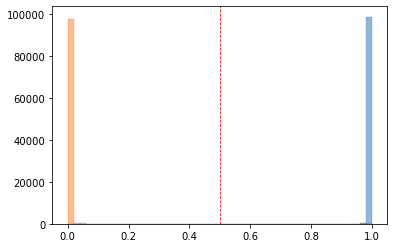

In [41]:
# We can set the number of bins with the *bins* keyword argument.
fig, axs = plt.subplots()
e_scores = ml_answers[:,0]
pi_scores = ml_answers[:,1]

axs.axvline(x=0.5, color='red', linestyle='--', linewidth=0.8)
axs.hist(e_scores[all_vals_df.prt_name == "e-"], bins=50, alpha = 0.5, edgecolor='blue', linewidth=0.3)
axs.hist(1-pi_scores[all_vals_df.prt_name == "pi-"], bins=50, alpha = 0.5, edgecolor='red', linewidth=0.3)
#plt.yscale('log')
plt.plot()


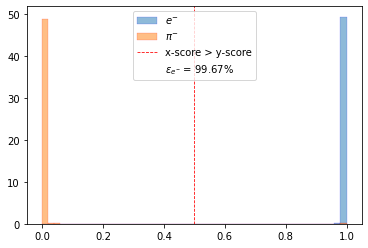

In [47]:
fig, axs = plt.subplots()

e_hist_data = e_scores[all_vals_df.prt_name == "e-"] 
pi_hist_data = 1-pi_scores[all_vals_df.prt_name == "pi-"]

axs.hist(e_hist_data, bins=50, alpha = 0.5, edgecolor='blue', linewidth=0.3, range=(0, 1), density=True, label="$e^{-}$")
axs.hist(pi_hist_data, bins=50, alpha = 0.5, edgecolor='red', linewidth=0.3, range=(0, 1), density=True, label="$\pi^{-}$")
axs.axvline(x=0.5, color='red', linestyle='--', linewidth=0.8, label=f"x-score > y-score")
axs.plot([], [], ' ', label="$\epsilon_{e^{-}}$ = 99.67%")
#axs.plot([], [], ' ', label="$\epsilon_{\pi^{-}}$ = " + f"{n_pi_above*100:.2f}%")
axs.legend(loc='upper center')